<a href="https://colab.research.google.com/github/madysonic/scRNAseqtutorial/blob/main/Diff_Gene_Expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Day 2. Statistics in Single Cell RNA seq data**

We will use R for the remainder of this course, to set your google co lab to R language, change runtime type from Python to R.

We can't mount google drive to co-lab in R runtimes, so upload the X.csv, obs.csv and var.csv to the session storage.

(File icon on the left, then document with arrow on it)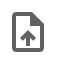

Be aware that if the runtime expires, you will have to reupload these files.
You can avoid your runtime expiring by keeping the co-lab notebook as a separate webpage.

**1. Install and load the required packages**

In [ ]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("limma")
install.packages('ggrepel')
install.packages("WebGestaltR")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'limma'”
Old packages: 'selectr', 'testthat', 'vroom', 'xml2', 'yaml'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘svglite’, ‘igraph’




In [ ]:
library(dplyr)
library(ggplot2)
library(tidyr)
library(limma)
library(ggrepel)
library(WebGestaltR)

ERROR: Error in library(WebGestaltR): there is no package called ‘WebGestaltR’


**1. Read in the 3 csv files**
* X is the expression matrix
* obs is the observations/metadata
* var is the gene names

In [ ]:
exp_data <- read.csv('/content/X.csv', header=FALSE)
metadata <-read.csv('/content/obs.csv')
var_data<- read.csv('/content/var.csv')

head(exp_data)
head(metadata)
head(var_data)

**2. Make the row names of exp_data be CellIDs, and the column names be gene names**

In [ ]:
rownames(exp_data)<-metadata$CellID
colnames(exp_data)<-var_data$Gene

head(exp_data)

##**Initial visualisations of the data**
**1. Calculate the total number of cells per patient**


In [ ]:
cells_per_patient <- metadata %>%
  group_by(Patient) %>%
  tally()
names(cells_per_patient) <- c('Patient','Total_Cells')
cells_per_patient

In [ ]:
head(cells_per_patient)

**2. Use ggplot to plot this as a bar graph**

In [ ]:
ggplot(cells_per_patient, aes(x = reorder(Patient, -Total_Cells), y = Total_Cells)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  labs(title = "Total Number of Cells per Patient", x = "Patient ID", y = "Total Number of Cells") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

**3. Calculate and plot total cell counts per disease stage**

In [ ]:
cells_per_stage <- metadata %>%
  group_by(Disease_stage) %>%
  tally()
names(cells_per_stage) <- c('Disease_stage','Total_Cells')

In [ ]:
ggplot(cells_per_stage, aes(x = Disease_stage, y = Total_Cells, fill = Disease_stage)) +
  geom_bar(stat = "identity") +
  labs(title = "Total Number of Cells per Disease Stage", x = "Disease Stage", y = "Total Number of Cells") +
  theme_minimal()

**4. Calculate and plot counts of cell types per disease stage**

In [ ]:
cell_counts <- metadata %>%
  group_by(Celltype, Disease_stage) %>%
  tally()

In [ ]:
ggplot(cell_counts, aes(x = Disease_stage, y = n, fill = Celltype)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Cell Type Distribution by Disease Stage", x = "Disease Stage", y = "Cell Count") +
  theme_minimal()

## **Differential gene expression**
* Perform a differential gene expression test between between Secretory Epithelial-1 and Secretory Epithelial-2 using the limma package

**1. Subset the metadata and expression data to the two secretory epithelial cell types**

In [ ]:
secretorymeta<- subset(metadata, metadata$Celltype %in%c('Secretory Epithelial-1','Secretory Epithelial-2'))
secretoryexp<- subset(exp_data, rownames(exp_data) %in% secretorymeta$CellID)

**2.Check dimensions of secretory cell metadata and expression match, do they have the same number of cells?**


In [ ]:
dim(secretorymeta)
dim(secretoryexp)

**3. Transpose the expression matrix, so columns = cells and rows = genes
(this is the input format required by limma)**
* Check cell IDs match

In [ ]:
secretoryexp <- t(secretoryexp)
identical(colnames(secretoryexp), secretorymeta$CellID)

**4. Perform differential gene expression test**

In [ ]:
design <- model.matrix(~ Celltype, data = secretorymeta)
fit <- lmFit(secretoryexp, design)
fit <- eBayes(fit, trend = TRUE)

**5. Print top 20 differentially expressed gene**

In [ ]:
top20genes <- topTable(fit, coef = 2, number = 20)
print(top20genes)

**6. Plot a volcano plot of top 100 differentially expressed genes**

In [ ]:
top_genes_df <- topTable(fit, coef = 2, number = 100)
top_genes_df$significance <- ifelse(top_genes_df$P.Value < 0.05 & abs(top_genes_df$logFC) > 1,
                                    "Significant", "Not Significant")

In [ ]:
volcanoplot <- ggplot(top_genes_df, aes(x = logFC, y = -log10(P.Value), color = significance)) +
  geom_point(alpha = 0.6, size = 2) +
  scale_color_manual(values = c("Not Significant" = "gray", "Significant" = "red")) +
  theme_minimal() +
  labs(title = "Volcano Plot of Differential Expression",
       x = "Log2 Fold Change", y = "-Log10(p-value)") +
  theme(legend.title = element_blank()) +
  theme(legend.position = "top")

volcanoplot

**7. Add gene names to the singificantly differentially expressed genes**

In [ ]:
volcanoplotlabelled <- volcanoplot +
  geom_text_repel(aes(label = ifelse(significance == "Significant", rownames(top_genes_df), "")),
                                                       box.padding = 0.5, point.padding = 0.5,
                                                       max.overlaps = 10, size = 3)
volcanoplotlabelled

##**Gene Set Enrichment Analysis**
* We can get more information about what biological processes or pathways each cell type might be enriched for using gene set enrichment analysis
* This will use a package WebGestaltR

**1. Import the list of ranked genes from cell types we generated using Scanpy yesterday**

In [ ]:
rankedgenes <- read.csv("/content/celltypemarkergenes.csv")
head(rankedgenes)


**2. We will look at Secretory Epithelial-1, Secretory Epithelial-2 and STIC lesion cell clusters**
* Create  subsets of gene files for each cell type



In [ ]:
SE1 <- rankedgenes[, colnames(rankedgenes) %in% c('Secretory.Epithelial.1_n', 'Secretory.Epithelial.1_s'), drop = FALSE]
SE2 <- rankedgenes[, colnames(rankedgenes) %in% c('Secretory.Epithelial.2_n', 'Secretory.Epithelial.2_s'), drop = FALSE]
STIC <- rankedgenes[, colnames(rankedgenes) %in% c('STIC.lesion_n', 'STIC.lesion_s'), drop = FALSE]


In [ ]:
SE1

**3. Save as rank files for input to webgestalt**

In [ ]:
write.table(SE1, file = "/content/SE1rankedgenes.rnk", sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)
write.table(SE2, file = "/content/SE2rankedgenes.rnk", sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)
write.table(STIC, file = "/content/STICrankedgenes.rnk", sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)

In [ ]:
SE1

**4. Run Webgestalt GSEA for each rank file**

In [ ]:
SE1Result <- WebGestaltR(
  enrichMethod = "GSEA", organism = "hsapiens",
  enrichDatabase = "pathway_KEGG", interestGeneFile = "/content/SE1rankedgenes.rnk",
  interestGeneType = "genesymbol", sigMethod = "top", topThr = 10, minNum = 5)

SE2Result <- WebGestaltR(
  enrichMethod = "GSEA", organism = "hsapiens",
  enrichDatabase = "pathway_KEGG", interestGeneFile = "/content/SE2rankedgenes.rnk",
  interestGeneType = "genesymbol", sigMethod = "top", topThr = 10, minNum = 5)

STICResult <- WebGestaltR(
  enrichMethod = "GSEA", organism = "hsapiens",
  enrichDatabase = "pathway_KEGG", interestGeneFile = "/content/STICrankedgenes.rnk",
  interestGeneType = "genesymbol", sigMethod = "top", topThr = 10, minNum = 5)

Try different databases, use listGeneSet() to view the databases available

**5. To plot a dotplot of all the results combined**
* Add a column to each result table identify cell type
* Join the results tables together

In [ ]:
SE1Result$Celltype = 'Secretory Epithelial-1'
SE2Result$Celltype = 'Secretory Epithelial-2'
STICResult$Celltype = 'STIC lesion'
gsea<- SE1Result %>% bind_rows(SE2Result) %>% bind_rows(STICResult)
head(gsea)

**6. Plot the dot plot**

In [ ]:
ggplot(gsea, aes(x = Celltype, y = description)) +
  geom_point(aes(size= FDR, color = pValue)) +
  scale_color_gradient(low = "red", high = "blue", name = "pValue") +
  scale_size_continuous(range = c(0.2, 15)) +
  theme_minimal() +
  labs(
    title = "GeneSetEnrichmentAnalysis for Secretory epithelial cells and STIC lesions",
    x = "Cell Types",
    y = "Pathway Description"
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        plot.title = element_text(size = 14, face = "bold", hjust = 0.8))

##**Linear regression**
* We can assess correlations in gene expression between 2 genes in one or two cell types

**1. Subset the data to secretory epithelial-1 and secretory epithelial-2 again**



In [ ]:
secretorymeta<- subset(metadata, metadata$Celltype %in%c('Secretory Epithelial-1','Secretory Epithelial-2'))
secretoryexp<- subset(exp_data, rownames(exp_data) %in% secretorymeta$CellID)

**2. Create a new column in the metadata with JUNB and IER2 expression for each cell**

In [ ]:
secretorymeta$JUNB<-exp_data[row.names(secretoryexp),"JUNB"]
secretorymeta$IER2<-exp_data[row.names(secretoryexp),"IER2"]


**3. Subset the secretory metadata to contain only cells with JUNB and IER2 expression equal to or greater than 0**

In [ ]:
filtered_meta <- secretorymeta %>%
  filter(JUNB >= 0 & IER2 >= 0)


**4. Run the linear regression model**

In [ ]:
model <- lm(JUNB ~ IER2, data = filtered_meta)
summary(model)

**5.Create a scatter plot of JUNB expression vs IER2 expression**

In [ ]:
geneexpression <- ggplot(filtered_meta, aes(x = JUNB, y = IER2)) +
                geom_point() +
                geom_smooth(method = "lm", color = "red", se = TRUE) +
                theme_minimal() +
                labs(title = "JUNB Expression vs.IER2 Expression",
                x = "JUNB Expression",
                y = "IER2 Expression") +
                theme(axis.text.x = element_text(angle = 45, hjust = 1))
geneexpression

**6. Add the Rsquared value onto the plot**

In [ ]:
r_squared <- summary(model)$r.squared

geneexpression<- geneexpression + annotate("text", x = 2, y = 2.5, label = paste("R² = ", round(r_squared,3)), size=6)
geneexpression


**7.Colour the points by disease stage or tissue type**


In [ ]:
stagegeneexpression<- geneexpression + geom_point(aes(color=Disease_stage))
stagegeneexpression

tissuegeneexpression<- geneexpression + geom_point(aes(color=Tissue))
tissuegeneexpression

##**Correlate several genes against eachother using a correlation matrix**

**1. Remove values with a standard deviation of 0, as this will break the correlation matrix**

In [ ]:
secretoryexp<- secretoryexp[,apply(secretoryexp,2, sd) > 0]

**2. Correlate genes against eachother**

In [ ]:
cordata<-cor(secretoryexp [colnames(secretoryexp)],
             secretoryexp[colnames(secretoryexp)])

**3. Plot a heatmap of the correlation matrix of genes with a correlation score of >0.6**
* Define the genes with a correlation score of >0.6
* Subset the correlation matrix to these genes only
* Plot as a heatmap

In [ ]:
upper_tri <- upper.tri(cordata)
high_corr<-which(upper_tri & cordata>0.6, arr.ind=TRUE)

corrplot <- cordata[rownames(cordata) %in% rownames(high_corr),]
corrplot <- corrplot[,colnames(corrplot) %in% rownames(high_corr)]

heatmap(corrplot)
